# Thermal modelling based on a dynamic profile and a distribution transformer

In this example the following concepts are shown:
*  Modelling of a distribution transformer;
*  Setting the minimal required transformer specifications;
*  Modelling with a dynamic load and ambient profile.

Before we start modelling the transformer, we will first import all the required functions and classes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from transformer_thermal_model.model import Model
from transformer_thermal_model.schemas import InputProfile, UserTransformerSpecifications
from transformer_thermal_model.transformer import DistributionTransformer

The data, a load profile and an ambient temperature profile, are generated for this example and cover three days. The load is a simple sine with a wavelength of half a day. The ambient temperature is constant over the given period.
The data can be combined into an `InputProfile` object.

In [2]:
datetime_index = [pd.to_datetime("2025-07-01 00:00:00") + pd.Timedelta(minutes=15 * i) for i in np.arange(0, 288)]

load_series = pd.Series(data=np.sin(np.arange(0, 288) * 900 * 2 * np.pi * 1 / 43200) * 500 + 500, index=datetime_index)
ambient_series = pd.Series(data=20, index=datetime_index)

# Create an input object with the profiles
profile_input = InputProfile.create(
    datetime_index=datetime_index, load_profile=load_series, ambient_temperature_profile=ambient_series
)

The next step is to create a distribution transformer object. We will use the default specifications of the distribution transformer. Additionally, there are four mandatory specifications to be set: 
* The nominal current at the secondary side [A]
* The load loss [W]
* The no-load loss [W]
* The ambient temperature surcharge [K]

The four specifications are set using the `UserTransformerSpecifications` object.

Note that the cooling type is ONAN by default for distribution transformers.


In [3]:
transformer_specifications = UserTransformerSpecifications(
    load_loss=5200,  # Transformer load loss [W]
    nom_load_sec_side=900,  # Transformer nominal current secondary side [A]
    no_load_loss=800,  # Transformer no-load loss [W]
    amb_temp_surcharge=10,  # Ambient temperature surcharge [K]
)
transformer = DistributionTransformer(user_specs=transformer_specifications)

The default specifications of a transformer can be consulted with the `default` property:

In [4]:
transformer.defaults

DefaultTransformerSpecifications(time_const_oil=180.0, time_const_windings=4.0, top_oil_temp_rise=60.0, winding_oil_gradient=23.0, hot_spot_fac=1.2, oil_const_k11=1.0, winding_const_k21=1, winding_const_k22=2, oil_exp_x=0.8, winding_exp_y=1.6, end_temp_reduction=0.0)

The specifications that are used in the thermal model can consulted in the `specs` property.
Note that the `defaults` and the `specs` can differ. 

In [5]:
transformer.specs

TransformerSpecifications(no_load_loss=800.0, amb_temp_surcharge=10.0, time_const_oil=180.0, time_const_windings=4.0, top_oil_temp_rise=60.0, winding_oil_gradient=23.0, hot_spot_fac=1.2, oil_const_k11=1.0, winding_const_k21=1, winding_const_k22=2, oil_exp_x=0.8, winding_exp_y=1.6, end_temp_reduction=0.0, load_loss=5200.0, nom_load_sec_side=900.0)

Now it is time to create a model based on the transformer and the profiles and run the model to create a temperature profile of the top-oil and the hot-spot.

In [6]:
model = Model(temperature_profile=profile_input, transformer=transformer)

results = model.run()

The output, `results`, contains to output profiles: the top-oil temperature profile and the hot-spot temperature profile. Lets plot them to see how warm our transformer became in this summer week.  

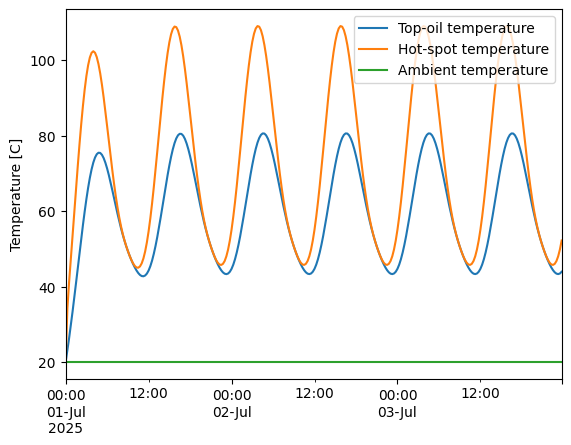

In [7]:
fig = plt.figure()
ax = results.top_oil_temp_profile.plot(label="Top-oil temperature")
results.hot_spot_temp_profile.plot(label="Hot-spot temperature")
ambient_series.plot(label="Ambient temperature")
ax.set_ylabel("Temperature [C]")

ax.legend();